In [1]:
import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xlsxwriter

In [2]:
tf.random.set_seed(2)
np.random.seed(2)

In [3]:
class AdaptiveLayer(keras.layers.Layer):
    
    def __init__(self, units, structure=[2, 2], inner_hidden_activation=tf.nn.tanh, 
                 inner_out_activation=lambda x : x, skip_w=0.0):
        super().__init__()
        self.units = units
        self.structure = structure
        self.inner_hidden_activation = inner_hidden_activation
        self.inner_out_activation = inner_out_activation
        self.skip_w = skip_w
        
        
    def build(self, input_shape):
        self.outer_w = self.add_weight(shape=(input_shape[-1], self.units), initializer="random_normal")
        self.outer_b = self.add_weight(shape=(self.units), initializer="zeros")
        
        self.inner_w = []
        self.inner_b = []
        for i in range(len(self.structure)):
            if i == 0:
                self.inner_w.append(self.add_weight(shape=(self.units, 1, self.structure[i]), 
                                          initializer=tf.initializers.random_normal(stddev=1.5)))
            else:
                self.inner_w.append(self.add_weight(shape=(self.units, self.structure[i-1], self.structure[i]), 
                                          initializer=tf.initializers.random_normal(stddev=0.9)))
            
            self.inner_b.append(self.add_weight(shape=(self.units, 1, self.structure[i]), initializer="zeros"))
   

    def call(self, inputs):
        z = inputs @ self.outer_w + self.outer_b
        a = tf.expand_dims(tf.transpose(z), axis=-1)
        
        for i in range(len(self.structure)-1):
            a = a @ self.inner_w[i] + self.inner_b[i]
            a = self.inner_hidden_activation(a)
        
        if len(self.structure) > 0:
            a = a @ self.inner_w[-1] + self.inner_b[-1]
        
        a = tf.reshape(tf.transpose(a), shape=(len(inputs), self.units))
        a = self.inner_out_activation(a+z*self.skip_w)
        
        return a
        

    def activation_show(self, inputs):
        inner_z = tf.cast(tf.expand_dims(tf.transpose(inputs), axis=-1), dtype=tf.float32)
        a = tf.expand_dims(tf.transpose(inner_z), axis=-1)
        
        for i in range(len(self.structure)-1):
            a = a @ self.inner_w[i] + self.inner_b[i]
            a = self.inner_hidden_activation(a)
        
        a = a @ self.inner_w[-1] + self.inner_b[-1]
        
        a = tf.reshape(tf.transpose(a), shape=(len(inputs), self.units))
        a = self.inner_out_activation(a)
        
        return a

In [4]:
class AdaptiveLayerConv(keras.layers.Layer):
    
    def __init__(self, units, structure=[4, 8], split=2, inner_hidden_activation=tf.nn.tanh, 
                 inner_out_activation=lambda x : x, skip_w=0.9, noise=0.0):
        super().__init__()
        self.units = units
        self.structure = structure
        self.split = split
        self.inner_hidden_activation = inner_hidden_activation
        self.inner_out_activation = inner_out_activation
        self.skip_w = skip_w
        self.noise = noise
        
        
    def build(self, input_shape):
        
        self.outer_w = self.add_weight(shape=(self.split, input_shape[-1], self.units),
                                                  initializer="random_normal")
        self.outer_b = self.add_weight(shape=(self.split, self.units), initializer="zeros")
        
        self.inner_w = []
        for i in range(0, len(self.structure)):
            self.inner_w.append(keras.layers.Conv1D(self.structure[i], 1, 
                                                       activation=self.inner_hidden_activation))
            
        self.inner_w.append(keras.layers.AveragePooling1D(pool_size=self.split, data_format='channels_first'))      
        self.inner_w.append(keras.layers.Conv1D(self.units, 1)) 

   
    def call(self, inputs):
        z = []
        for i in range(0, self.split):
            noise = tf.random.truncated_normal(shape=(self.outer_b[i].shape))
            z.append(inputs @ self.outer_w[i] + self.outer_b[i] + noise*self.noise)
        
        a = tf.cast(z, dtype=tf.float32)
        z = tf.cast(z, dtype=tf.float32)
        
        for i in range(len(self.inner_w)-2):
            a = self.inner_w[i](a)
        
        if len(self.inner_w) > 0:
            a = self.inner_w[-2](tf.transpose(a))
            a = self.inner_w[-1](tf.transpose(a))
    
        a = tf.reshape(a, shape=(-1, self.units))
        z_skip = tf.reduce_sum(z, axis=0)/self.split     
        
        a = self.inner_out_activation(a + z_skip*self.skip_w)
        
        return a    

    def activation_show(self, inputs):
        tmp = []
        for i in range(0, self.units):
            tmp.append(inputs)
        
        tmp = tf.cast(tmp, dtype=tf.float32)
        a = tf.expand_dims(tf.transpose(tmp), axis=0)
            
        for i in range(len(self.inner_w)-2):
            a = self.inner_w[i](a)
             
        a = self.inner_w[len(self.inner_w)-1](a)
        a = tf.reshape(a, shape=(-1, self.units))
        a = self.inner_out_activation(a)
        
        return a
        


In [5]:
class AdaptiveModel(keras.Model):
    
    def __init__(self, l=[AdaptiveLayer(2), AdaptiveLayer(1)]):
        super().__init__()
        self.l = l

    def call(self, inputs):
        a = inputs
        for layer in self.l:
            a = layer(a)
        
        return a
        
    def activation_show(self, inputs):
        y = []
        
        for layer in self.l:
            tmp = layer.activation_show(inputs)
            
            for i in range(tmp.shape[-1]):
                y.append(tmp[:, i])
        
        return y
        

In [6]:
# dataset

data = pd.read_csv('../datasets/sonar_data.csv')
data = pd.DataFrame(data).to_numpy()
np.random.shuffle(data)

x = data[:, :-1]
y = data[:, -1]

x = np.array(x, dtype=np.float32)
y = np.array([out == 'M' for out in (y)], dtype=np.float32)

x_train, x_test = x[:160, :], x[160:, :]
y_train, y_test = y[:160], y[160:]

y_train = tf.constant(y_train, shape=(y_train.shape[0], 1))
y_test = tf.constant(y_test, shape=(y_test.shape[0], 1))

In [7]:
# Adaptive Layer (no inner_structure)
# 341 params
adaptive_nn_model_no_inner = AdaptiveModel([
    AdaptiveLayer(5, structure=[], inner_out_activation=tf.nn.sigmoid, skip_w=0),
    AdaptiveLayer(5, structure=[], inner_out_activation=tf.nn.sigmoid, skip_w=0),
    AdaptiveLayer(1, structure=[], inner_out_activation=tf.nn.sigmoid, skip_w=0)
])

In [8]:
# Adaptive Layer (with inner_structure)
# 353 params
adaptive_nn_model_with_inner = AdaptiveModel([
    AdaptiveLayer(5, structure=[2, 1], inner_out_activation=tf.nn.sigmoid, skip_w=0.1),
    AdaptiveLayer(1, structure=[2, 1], inner_out_activation=tf.nn.sigmoid, skip_w=0.1)
])

In [9]:
# Adaptive Layer based on 1D Conv (no inner_structure)
# 386 params
adaptive_conv_nn_model_no_inner = AdaptiveModel([
    AdaptiveLayerConv(5, structure=[], split=1, skip_w=0, noise=0, inner_out_activation=tf.nn.sigmoid),
    AdaptiveLayerConv(4, structure=[], split=1, skip_w=0, noise=0, inner_out_activation=tf.nn.sigmoid),
    AdaptiveLayerConv(1, structure=[], split=1, skip_w=0, noise=0, inner_out_activation=tf.nn.sigmoid)
])

In [10]:
# Adaptive Layer based on 1D Conv (with inner_structure)
# 381 params
adaptive_conv_nn_model_with_inner = AdaptiveModel([
    AdaptiveLayerConv(5, structure=[2, 4], split=1, skip_w=0.1, noise=0, inner_out_activation=tf.nn.sigmoid),
    AdaptiveLayerConv(1, structure=[2, 4], split=1, skip_w=0.1, noise=0, inner_out_activation=tf.nn.sigmoid)
])

In [11]:
tmp = adaptive_nn_model_no_inner.predict(x_test)
tmp = adaptive_nn_model_with_inner.predict(x_test)
tmp = adaptive_conv_nn_model_no_inner.predict(x_test)
tmp = adaptive_conv_nn_model_with_inner.predict(x_test)

2/2 [==============================] - 0s 1ms/step


In [12]:
def extract_weights(model, outter=True, conv=False):
    tmp = []
    for i in range(len(model.l)):
        if outter:
            tmp.append(model.l[i].outer_w.numpy())
        else:
            if not conv:
                tmp.append(model.l[i].inner_w[0].numpy())
            else:
                tmp.append(model.l[i].inner_w[0].weights[0].numpy())
    
    return tmp

In [13]:
adaptive_nn_model_with_inner.l[0].inner_w[0].numpy()

array([[[ 3.331327  ,  1.3756878 ]],

       [[ 1.9870344 , -4.192154  ]],

       [[ 2.187041  ,  0.1368651 ]],

       [[-2.9338264 ,  3.8549056 ]],

       [[ 0.28396088,  1.9528294 ]]], dtype=float32)

In [14]:
initial_outer_w_anm_no_inner = extract_weights(adaptive_nn_model_no_inner)
initial_outer_w_anm_with_inner = extract_weights(adaptive_nn_model_with_inner)
initial_inner_w_anm_with_inner = extract_weights(adaptive_nn_model_with_inner, outter=False)
initial_outer_w_acnm_no_inner = extract_weights(adaptive_conv_nn_model_no_inner)
initial_outer_w_acnm_with_inner = extract_weights(adaptive_conv_nn_model_with_inner)
initial_inner_w_acnm_with_inner = extract_weights(adaptive_conv_nn_model_with_inner, outter=False, conv=True)

In [15]:
adaptive_nn_model_no_inner.compile(optimizer=tf.optimizers.legacy.Adam(learning_rate=0.003), 
                       loss="binary_crossentropy", metrics=['accuracy'])

In [16]:
adaptive_nn_model_with_inner.compile(optimizer=tf.optimizers.legacy.Adam(learning_rate=0.003), 
                       loss="binary_crossentropy", metrics=['accuracy'])

In [17]:
adaptive_conv_nn_model_no_inner.compile(optimizer=tf.optimizers.legacy.Adam(learning_rate=0.003), 
                       loss="binary_crossentropy", metrics=['accuracy'])

In [18]:
adaptive_conv_nn_model_with_inner.compile(optimizer=tf.optimizers.legacy.Adam(learning_rate=0.003), 
                       loss="binary_crossentropy", metrics=['accuracy'])

In [19]:
EPOCHS = 10

In [20]:
adaptive_nn_model_no_inner.fit(x_train, y_train, epochs=EPOCHS)

Epoch 1/10
5/5 [==============================] - 0s 1ms/step - loss: 0.6927 - accuracy: 0.5562
Epoch 2/10
5/5 [==============================] - 0s 987us/step - loss: 0.6905 - accuracy: 0.5562
Epoch 3/10
5/5 [==============================] - 0s 988us/step - loss: 0.6894 - accuracy: 0.5562
Epoch 4/10
5/5 [==============================] - 0s 903us/step - loss: 0.6890 - accuracy: 0.5562
Epoch 5/10
5/5 [==============================] - 0s 1ms/step - loss: 0.6880 - accuracy: 0.5562
Epoch 6/10
5/5 [==============================] - 0s 847us/step - loss: 0.6877 - accuracy: 0.5562
Epoch 7/10
5/5 [==============================] - 0s 880us/step - loss: 0.6876 - accuracy: 0.5562
Epoch 8/10
5/5 [==============================] - 0s 1ms/step - loss: 0.6871 - accuracy: 0.5562
Epoch 9/10
5/5 [==============================] - 0s 770us/step - loss: 0.6870 - accuracy: 0.5562
Epoch 10/10
5/5 [==============================] - 0s 908us/step - loss: 0.6868 - accuracy: 0.5562


In [21]:
adaptive_nn_model_with_inner.fit(x_train, y_train, epochs=EPOCHS)

Epoch 1/10
5/5 [==============================] - 0s 867us/step - loss: 0.6922 - accuracy: 0.5562
Epoch 2/10
5/5 [==============================] - 0s 716us/step - loss: 0.6863 - accuracy: 0.5562
Epoch 3/10
5/5 [==============================] - 0s 1ms/step - loss: 0.6849 - accuracy: 0.5562
Epoch 4/10
5/5 [==============================] - 0s 950us/step - loss: 0.6824 - accuracy: 0.5562
Epoch 5/10
5/5 [==============================] - 0s 1ms/step - loss: 0.6816 - accuracy: 0.5562
Epoch 6/10
5/5 [==============================] - 0s 961us/step - loss: 0.6775 - accuracy: 0.5562
Epoch 7/10
5/5 [==============================] - 0s 1ms/step - loss: 0.6754 - accuracy: 0.5562
Epoch 8/10
5/5 [==============================] - 0s 1ms/step - loss: 0.6717 - accuracy: 0.5562
Epoch 9/10
5/5 [==============================] - 0s 828us/step - loss: 0.6669 - accuracy: 0.5562
Epoch 10/10
5/5 [==============================] - 0s 1ms/step - loss: 0.6616 - accuracy: 0.5562


In [22]:
adaptive_conv_nn_model_no_inner.fit(x_train, y_train, epochs=EPOCHS)

Epoch 1/10
5/5 [==============================] - 0s 897us/step - loss: 0.6935 - accuracy: 0.4313
Epoch 2/10
5/5 [==============================] - 0s 977us/step - loss: 0.6921 - accuracy: 0.5562
Epoch 3/10
5/5 [==============================] - 0s 1ms/step - loss: 0.6912 - accuracy: 0.5562
Epoch 4/10
5/5 [==============================] - 0s 1ms/step - loss: 0.6908 - accuracy: 0.5562
Epoch 5/10
5/5 [==============================] - 0s 973us/step - loss: 0.6899 - accuracy: 0.5562
Epoch 6/10
5/5 [==============================] - 0s 1ms/step - loss: 0.6895 - accuracy: 0.5562
Epoch 7/10
5/5 [==============================] - 0s 915us/step - loss: 0.6892 - accuracy: 0.5562
Epoch 8/10
5/5 [==============================] - 0s 1ms/step - loss: 0.6886 - accuracy: 0.5562
Epoch 9/10
5/5 [==============================] - 0s 944us/step - loss: 0.6883 - accuracy: 0.5562
Epoch 10/10
5/5 [==============================] - 0s 1ms/step - loss: 0.6880 - accuracy: 0.5562


In [23]:
adaptive_conv_nn_model_with_inner.fit(x_train, y_train, epochs=EPOCHS)

Epoch 1/10
5/5 [==============================] - 0s 932us/step - loss: 0.6958 - accuracy: 0.4563
Epoch 2/10
5/5 [==============================] - 0s 798us/step - loss: 0.6918 - accuracy: 0.5562
Epoch 3/10
5/5 [==============================] - 0s 833us/step - loss: 0.6899 - accuracy: 0.5562
Epoch 4/10
5/5 [==============================] - 0s 1ms/step - loss: 0.6893 - accuracy: 0.5562
Epoch 5/10
5/5 [==============================] - 0s 1ms/step - loss: 0.6879 - accuracy: 0.5562
Epoch 6/10
5/5 [==============================] - 0s 1ms/step - loss: 0.6875 - accuracy: 0.5562
Epoch 7/10
5/5 [==============================] - 0s 1ms/step - loss: 0.6874 - accuracy: 0.5562
Epoch 8/10
5/5 [==============================] - 0s 1ms/step - loss: 0.6869 - accuracy: 0.5562
Epoch 9/10
5/5 [==============================] - 0s 1ms/step - loss: 0.6867 - accuracy: 0.5562
Epoch 10/10
5/5 [==============================] - 0s 1ms/step - loss: 0.6866 - accuracy: 0.5562


In [24]:
e10_outer_w_anm_no_inner = extract_weights(adaptive_nn_model_no_inner)
e10_outer_w_anm_with_inner = extract_weights(adaptive_nn_model_with_inner)
e10_inner_w_anm_with_inner = extract_weights(adaptive_nn_model_with_inner, outter=False)
e10_outer_w_acnm_no_inner = extract_weights(adaptive_conv_nn_model_no_inner)
e10_outer_w_acnm_with_inner = extract_weights(adaptive_conv_nn_model_with_inner)
e10_inner_w_acnm_with_inner = extract_weights(adaptive_conv_nn_model_with_inner, outter=False, conv=True)

In [25]:
print("10 - initial\nSUM:")
index = 0
print("outer_w_anm_no_inner", np.sum(np.abs(e10_outer_w_anm_no_inner[index] - initial_outer_w_anm_no_inner[index])))
print("outer_w_anm_with_inner", np.sum(np.abs(e10_outer_w_anm_with_inner[index] - initial_outer_w_anm_with_inner[index])))
print("inner_w_anm_with_inner", np.sum(np.abs(e10_inner_w_anm_with_inner[index] - initial_inner_w_anm_with_inner[index])))
print("outer_w_acnm_no_inner", np.sum(np.abs(e10_outer_w_acnm_no_inner[index] - initial_outer_w_acnm_no_inner[index])))
print("outer_w_acnm_with_inner", np.sum(np.abs(e10_outer_w_acnm_with_inner[index] - initial_outer_w_acnm_with_inner[index])))
print("inner_w_acnm_with_inner", np.sum(np.abs(e10_inner_w_acnm_with_inner[index] - initial_inner_w_acnm_with_inner[index])))
print("\nAVERAGE:")
print("outer_w_anm_no_inner", np.average(np.abs(e10_outer_w_anm_no_inner[index] - initial_outer_w_anm_no_inner[index])))
print("outer_w_anm_with_inner", np.average(np.abs(e10_outer_w_anm_with_inner[index] - initial_outer_w_anm_with_inner[index])))
print("inner_w_anm_with_inner", np.average(np.abs(e10_inner_w_anm_with_inner[index] - initial_inner_w_anm_with_inner[index])))
print("outer_w_acnm_no_inner", np.average(np.abs(e10_outer_w_acnm_no_inner[index] - initial_outer_w_acnm_no_inner[index])))
print("outer_w_acnm_with_inner", np.average(np.abs(e10_outer_w_acnm_with_inner[index] - initial_outer_w_acnm_with_inner[index])))
print("inner_w_acnm_with_inner", np.average(np.abs(e10_inner_w_acnm_with_inner[index] - initial_inner_w_acnm_with_inner[index])))


10 - initial
SUM:
outer_w_anm_no_inner 20.19879
outer_w_anm_with_inner 18.398155
inner_w_anm_with_inner 0.46549246
outer_w_acnm_no_inner 12.218704
outer_w_acnm_with_inner 12.559346
inner_w_acnm_with_inner 0.42807242

AVERAGE:
outer_w_anm_no_inner 0.067329295
outer_w_anm_with_inner 0.061327185
inner_w_anm_with_inner 0.046549246
outer_w_acnm_no_inner 0.040729012
outer_w_acnm_with_inner 0.04186449
inner_w_acnm_with_inner 0.042807244


In [26]:
EPOCHS = 90

In [27]:
adaptive_nn_model_no_inner.fit(x_train, y_train, epochs=EPOCHS)

Epoch 1/90
5/5 [==============================] - 0s 2ms/step - loss: 0.6869 - accuracy: 0.5562
Epoch 2/90
5/5 [==============================] - 0s 1ms/step - loss: 0.6865 - accuracy: 0.5562
Epoch 3/90
5/5 [==============================] - 0s 1ms/step - loss: 0.6865 - accuracy: 0.5562
Epoch 4/90
5/5 [==============================] - 0s 992us/step - loss: 0.6865 - accuracy: 0.5562
Epoch 5/90
5/5 [==============================] - 0s 955us/step - loss: 0.6866 - accuracy: 0.5562
Epoch 6/90
5/5 [==============================] - 0s 937us/step - loss: 0.6862 - accuracy: 0.5562
Epoch 7/90
5/5 [==============================] - 0s 783us/step - loss: 0.6862 - accuracy: 0.5562
Epoch 8/90
5/5 [==============================] - 0s 1ms/step - loss: 0.6861 - accuracy: 0.5562
Epoch 9/90
5/5 [==============================] - 0s 792us/step - loss: 0.6860 - accuracy: 0.5562
Epoch 10/90
5/5 [==============================] - 0s 857us/step - loss: 0.6859 - accuracy: 0.5562
Epoch 11/90
5/5 [==========

In [28]:
adaptive_nn_model_with_inner.fit(x_train, y_train, epochs=EPOCHS)

Epoch 1/90
5/5 [==============================] - 0s 2ms/step - loss: 0.6564 - accuracy: 0.5562
Epoch 2/90
5/5 [==============================] - 0s 2ms/step - loss: 0.6478 - accuracy: 0.5875
Epoch 3/90
5/5 [==============================] - 0s 2ms/step - loss: 0.6409 - accuracy: 0.6938
Epoch 4/90
5/5 [==============================] - 0s 1ms/step - loss: 0.6309 - accuracy: 0.6938
Epoch 5/90
5/5 [==============================] - 0s 2ms/step - loss: 0.6251 - accuracy: 0.7375
Epoch 6/90
5/5 [==============================] - 0s 848us/step - loss: 0.6075 - accuracy: 0.7563
Epoch 7/90
5/5 [==============================] - 0s 1ms/step - loss: 0.5978 - accuracy: 0.7312
Epoch 8/90
5/5 [==============================] - 0s 910us/step - loss: 0.5834 - accuracy: 0.7812
Epoch 9/90
5/5 [==============================] - 0s 859us/step - loss: 0.5671 - accuracy: 0.8125
Epoch 10/90
5/5 [==============================] - 0s 986us/step - loss: 0.5510 - accuracy: 0.7750
Epoch 11/90
5/5 [==============

In [29]:
adaptive_conv_nn_model_no_inner.fit(x_train, y_train, epochs=EPOCHS)

Epoch 1/90
5/5 [==============================] - 0s 1ms/step - loss: 0.6879 - accuracy: 0.5562
Epoch 2/90
5/5 [==============================] - 0s 2ms/step - loss: 0.6873 - accuracy: 0.5562
Epoch 3/90
5/5 [==============================] - 0s 894us/step - loss: 0.6872 - accuracy: 0.5562
Epoch 4/90
5/5 [==============================] - 0s 2ms/step - loss: 0.6871 - accuracy: 0.5562
Epoch 5/90
5/5 [==============================] - 0s 892us/step - loss: 0.6869 - accuracy: 0.5562
Epoch 6/90
5/5 [==============================] - 0s 2ms/step - loss: 0.6866 - accuracy: 0.5562
Epoch 7/90
5/5 [==============================] - 0s 877us/step - loss: 0.6866 - accuracy: 0.5562
Epoch 8/90
5/5 [==============================] - 0s 1ms/step - loss: 0.6863 - accuracy: 0.5562
Epoch 9/90
5/5 [==============================] - 0s 1ms/step - loss: 0.6861 - accuracy: 0.5562
Epoch 10/90
5/5 [==============================] - 0s 892us/step - loss: 0.6858 - accuracy: 0.5562
Epoch 11/90
5/5 [==============

In [30]:
adaptive_conv_nn_model_with_inner.fit(x_train, y_train, epochs=EPOCHS)

Epoch 1/90
5/5 [==============================] - 0s 2ms/step - loss: 0.6865 - accuracy: 0.5562
Epoch 2/90
5/5 [==============================] - 0s 1ms/step - loss: 0.6860 - accuracy: 0.5562
Epoch 3/90
5/5 [==============================] - 0s 1ms/step - loss: 0.6858 - accuracy: 0.5562
Epoch 4/90
5/5 [==============================] - 0s 1ms/step - loss: 0.6852 - accuracy: 0.5562
Epoch 5/90
5/5 [==============================] - 0s 1ms/step - loss: 0.6849 - accuracy: 0.5562
Epoch 6/90
5/5 [==============================] - 0s 1ms/step - loss: 0.6832 - accuracy: 0.5562
Epoch 7/90
5/5 [==============================] - 0s 1ms/step - loss: 0.6818 - accuracy: 0.5562
Epoch 8/90
5/5 [==============================] - 0s 929us/step - loss: 0.6792 - accuracy: 0.5562
Epoch 9/90
5/5 [==============================] - 0s 2ms/step - loss: 0.6752 - accuracy: 0.5562
Epoch 10/90
5/5 [==============================] - 0s 928us/step - loss: 0.6687 - accuracy: 0.5562
Epoch 11/90
5/5 [==================

In [31]:
e100_outer_w_anm_no_inner = extract_weights(adaptive_nn_model_no_inner)
e100_outer_w_anm_with_inner = extract_weights(adaptive_nn_model_with_inner)
e100_inner_w_anm_with_inner = extract_weights(adaptive_nn_model_with_inner, outter=False)
e100_outer_w_acnm_no_inner = extract_weights(adaptive_conv_nn_model_no_inner)
e100_outer_w_acnm_with_inner = extract_weights(adaptive_conv_nn_model_with_inner)
e100_inner_w_acnm_with_inner = extract_weights(adaptive_conv_nn_model_with_inner, outter=False, conv=True)

In [32]:
print("100 - initial\nSUM:")
index = 0
print("outer_w_anm_no_inner", np.sum(np.abs(e100_outer_w_anm_no_inner[index] - initial_outer_w_anm_no_inner[index])))
print("outer_w_anm_with_inner", np.sum(np.abs(e100_outer_w_anm_with_inner[index] - initial_outer_w_anm_with_inner[index])))
print("inner_w_anm_with_inner", np.sum(np.abs(e100_inner_w_anm_with_inner[index] - initial_inner_w_anm_with_inner[index])))
print("outer_w_acnm_no_inner", np.sum(np.abs(e100_outer_w_acnm_no_inner[index] - initial_outer_w_acnm_no_inner[index])))
print("outer_w_acnm_with_inner", np.sum(np.abs(e100_outer_w_acnm_with_inner[index] - initial_outer_w_acnm_with_inner[index])))
print("inner_w_acnm_with_inner", np.sum(np.abs(e100_inner_w_acnm_with_inner[index] - initial_inner_w_acnm_with_inner[index])))
print("\nAVERAGE:")
print("outer_w_anm_no_inner", np.average(np.abs(e100_outer_w_anm_no_inner[index] - initial_outer_w_anm_no_inner[index])))
print("outer_w_anm_with_inner", np.average(np.abs(e100_outer_w_anm_with_inner[index] - initial_outer_w_anm_with_inner[index])))
print("inner_w_anm_with_inner", np.average(np.abs(e100_inner_w_anm_with_inner[index] - initial_inner_w_anm_with_inner[index])))
print("outer_w_acnm_no_inner", np.average(np.abs(e100_outer_w_acnm_no_inner[index] - initial_outer_w_acnm_no_inner[index])))
print("outer_w_acnm_with_inner", np.average(np.abs(e100_outer_w_acnm_with_inner[index] - initial_outer_w_acnm_with_inner[index])))
print("inner_w_acnm_with_inner", np.average(np.abs(e100_inner_w_acnm_with_inner[index] - initial_inner_w_acnm_with_inner[index])))


100 - initial
SUM:
outer_w_anm_no_inner 218.1046
outer_w_anm_with_inner 69.165344
inner_w_anm_with_inner 8.947897
outer_w_acnm_no_inner 100.35298
outer_w_acnm_with_inner 49.980484
inner_w_acnm_with_inner 4.4160023

AVERAGE:
outer_w_anm_no_inner 0.7270153
outer_w_anm_with_inner 0.23055115
inner_w_anm_with_inner 0.8947897
outer_w_acnm_no_inner 0.33450994
outer_w_acnm_with_inner 0.16660161
inner_w_acnm_with_inner 0.44160023


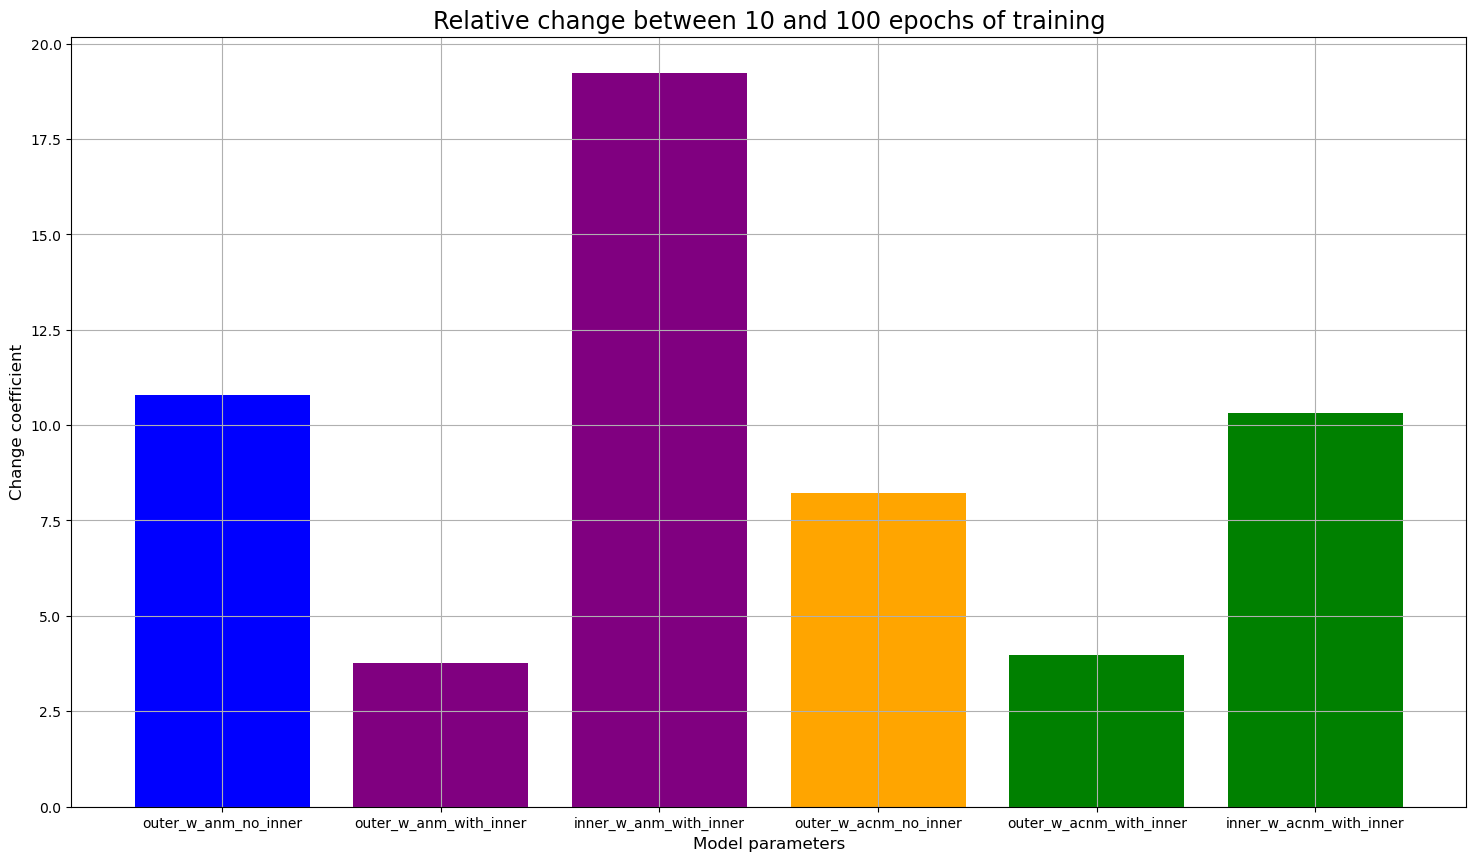

In [35]:
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot()

plt.title("Relative change between 10 and 100 epochs of training", fontsize="xx-large")

x = ['outer_w_anm_no_inner', 'outer_w_anm_with_inner', 'inner_w_anm_with_inner',
     'outer_w_acnm_no_inner', 'outer_w_acnm_with_inner', 'inner_w_acnm_with_inner']

y = [np.sum(np.abs(e100_outer_w_anm_no_inner[index] - initial_outer_w_anm_no_inner[index]))/np.sum(np.abs(e10_outer_w_anm_no_inner[index] - initial_outer_w_anm_no_inner[index])),
      np.sum(np.abs(e100_outer_w_anm_with_inner[index] - initial_outer_w_anm_with_inner[index]))/np.sum(np.abs(e10_outer_w_anm_with_inner[index] - initial_outer_w_anm_with_inner[index])),
      np.sum(np.abs(e100_inner_w_anm_with_inner[index] - initial_inner_w_anm_with_inner[index]))/np.sum(np.abs(e10_inner_w_anm_with_inner[index] - initial_inner_w_anm_with_inner[index])),
      np.sum(np.abs(e100_outer_w_acnm_no_inner[index] - initial_outer_w_acnm_no_inner[index]))/np.sum(np.abs(e10_outer_w_acnm_no_inner[index] - initial_outer_w_acnm_no_inner[index])),
      np.sum(np.abs(e100_outer_w_acnm_with_inner[index] - initial_outer_w_acnm_with_inner[index]))/np.sum(np.abs(e10_outer_w_acnm_with_inner[index] - initial_outer_w_acnm_with_inner[index])),
      np.sum(np.abs(e100_inner_w_acnm_with_inner[index] - initial_inner_w_acnm_with_inner[index]))/np.sum(np.abs(e10_inner_w_acnm_with_inner[index] - initial_inner_w_acnm_with_inner[index]))]

w = 0.8
plt.ylabel("Change coefficient", fontsize="large")
plt.xlabel("Model parameters", fontsize="large")
ax.bar(x, y, width=w, color=('blue', 'purple', 'purple', 'orange', 'green', 'green'))

plt.grid()
plt.show()

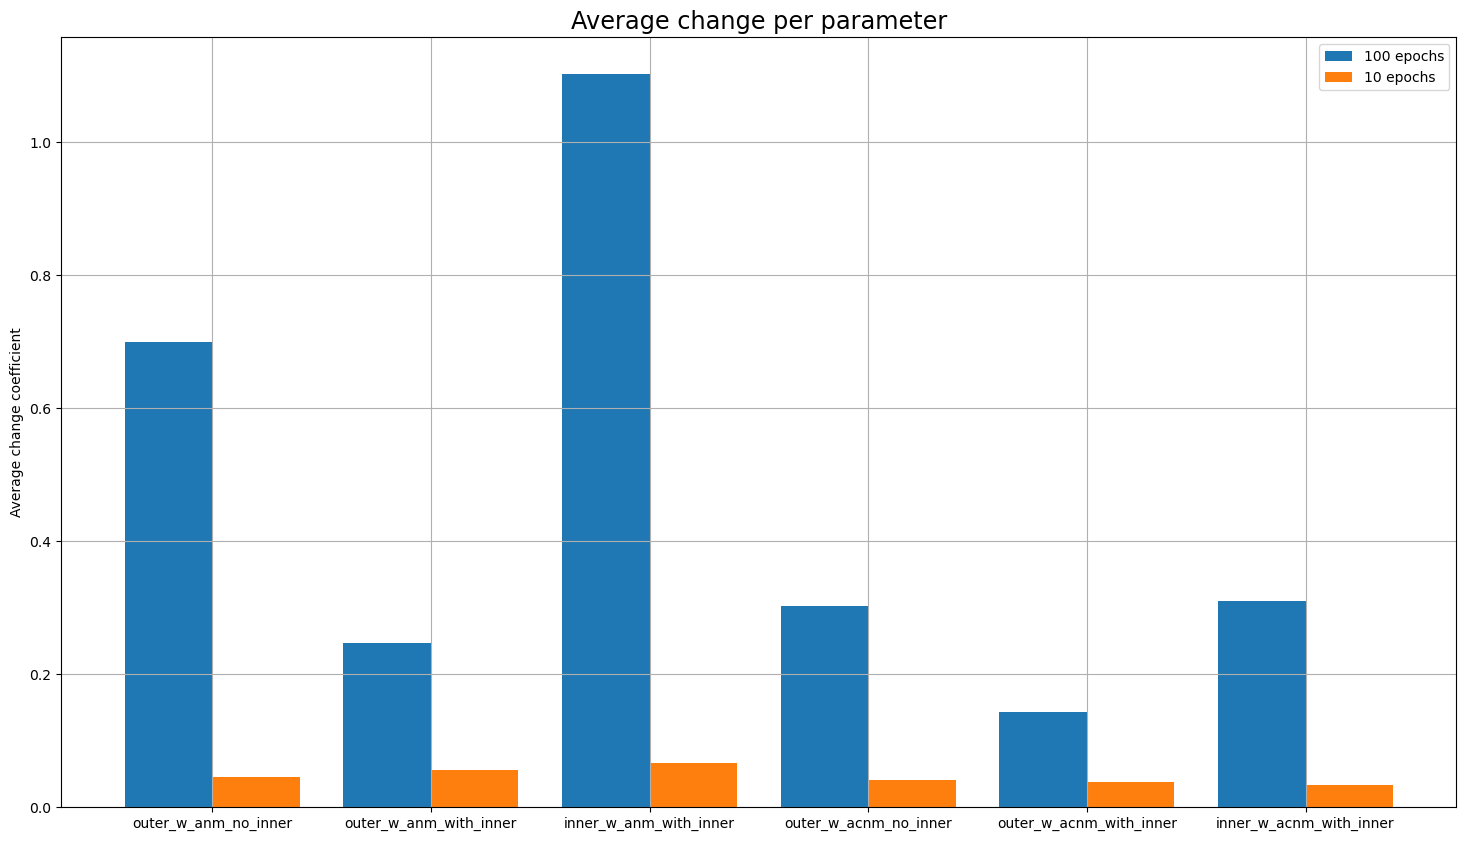

In [36]:
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot()

plt.title("Average change per parameter", fontsize="xx-large")

x = np.arange(6)
y1 = [np.average(np.abs(e100_outer_w_anm_no_inner[index] - initial_outer_w_anm_no_inner[index])),
      np.average(np.abs(e100_outer_w_anm_with_inner[index] - initial_outer_w_anm_with_inner[index])),
      np.average(np.abs(e100_inner_w_anm_with_inner[index] - initial_inner_w_anm_with_inner[index])),
      np.average(np.abs(e100_outer_w_acnm_no_inner[index] - initial_outer_w_acnm_no_inner[index])),
      np.average(np.abs(e100_outer_w_acnm_with_inner[index] - initial_outer_w_acnm_with_inner[index])),
      np.average(np.abs(e100_inner_w_acnm_with_inner[index] - initial_inner_w_acnm_with_inner[index]))]

y2 = [np.average(np.abs(e10_outer_w_anm_no_inner[index] - initial_outer_w_anm_no_inner[index])),
      np.average(np.abs(e10_outer_w_anm_with_inner[index] - initial_outer_w_anm_with_inner[index])),
      np.average(np.abs(e10_inner_w_anm_with_inner[index] - initial_inner_w_anm_with_inner[index])),
      np.average(np.abs(e10_outer_w_acnm_no_inner[index] - initial_outer_w_acnm_no_inner[index])),
      np.average(np.abs(e10_outer_w_acnm_with_inner[index] - initial_outer_w_acnm_with_inner[index])),
      np.average(np.abs(e10_inner_w_acnm_with_inner[index] - initial_inner_w_acnm_with_inner[index]))]

w = 0.4

plt.ylabel("Average change coefficient")
ax.bar(x - w/2, y1, width = w, label="100 epochs")
ax.bar(x + w/2, y2, width = w, label="10 epochs")

plt.xticks([r for r in range(len(y1))], 
        ['outer_w_anm_no_inner', 'outer_w_anm_with_inner', 'inner_w_anm_with_inner',
     'outer_w_acnm_no_inner', 'outer_w_acnm_with_inner', 'inner_w_acnm_with_inner'])

plt.legend()
plt.grid()
plt.show()